<a href="https://colab.research.google.com/github/yenchunR/NLP_HW4/blob/master/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import module

In [26]:
import os
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pprint import pprint
from IPython.display import clear_output 

In [27]:
!pip3 uninstall tensorflow-gpu==2.0.0-beta0
!pip3 uninstall -y tensorflow
!pip3 uninstall keras
clear_output()

In [28]:
!pip3 uninstall tensorflow-gpu==2.0.0-beta0
!pip3 install tensorflow-gpu==2.0.0-beta0
!pip3 uninstall tensorflow
!pip3 install tensorflow
clear_output()

In [29]:
!pip3 uninstall tensorflow-datasets
!pip3 install tensorflow-datasets
clear_output()

In [ ]:
!pip3 install --ignore-installed --upgrade --ignore-installed tensorflow
clear_output()

In [31]:
!pip3 install tensorflow-gpu==2.0.0-beta0
import tensorflow as tf
import tensorflow_datasets as tfds
clear_output()
print(tf.__version__)

2.6.0


In [ ]:
!pip3 list

## 改變 logging 等級

In [33]:
import logging
logging.basicConfig(level="ERROR")

np.set_printoptions(suppress=True) #讓 numpy 不要顯示科學記號

# 路徑變數

In [34]:
output_dir = "nmt"
en_vocab_file = os.path.join(output_dir, "en_vocab")
zh_vocab_file = os.path.join(output_dir, "zh_vocab")
checkpoint_path = os.path.join(output_dir, "checkpoints")
log_dir = os.path.join(output_dir, 'logs')
download_dir = "tensorflow-datasets/downloads"

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

# 建立輸入管道

## 下載並準備資料集

In [9]:
tmp_builder = tfds.builder("wmt19_translate/zh-en")
pprint(tmp_builder.subsets)

{Split('train'): ['newscommentary_v14',
                  'wikititles_v1',
                  'uncorpus_v1',
                  'casia2015',
                  'casict2011',
                  'casict2015',
                  'datum2015',
                  'datum2017',
                  'neu2017'],
 Split('validation'): ['newstest2018']}


## Download News Data

In [17]:
config = tfds.translate.wmt.WmtConfig(
    version="0.0.3",
    language_pair=("zh", "en"),
    subsets={
        tfds.Split.TRAIN: ["newscommentary_v14"]
    },
)
builder = tfds.builder("wmt_translate", config=config)
builder.download_and_prepare(download_dir=download_dir)
clear_output()

## 切割資料集

In [23]:
examples = builder.as_dataset(split=['train[:20%]','train[20%:21%]','train[21%:]'], as_supervised=True)

train_examples, val_examples, _ = examples
print(train_examples)
print(val_examples)

<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>
<PrefetchDataset shapes: ((), ()), types: (tf.string, tf.string)>


### Print Data

In [24]:
for en, zh in train_examples.take(3):
  print(en)
  print(zh)
  print('-' * 10)

tf.Tensor(b'The fear is real and visceral, and politicians ignore it at their peril.', shape=(), dtype=string)
tf.Tensor(b'\xe8\xbf\x99\xe7\xa7\x8d\xe6\x81\x90\xe6\x83\xa7\xe6\x98\xaf\xe7\x9c\x9f\xe5\xae\x9e\xe8\x80\x8c\xe5\x86\x85\xe5\x9c\xa8\xe7\x9a\x84\xe3\x80\x82 \xe5\xbf\xbd\xe8\xa7\x86\xe5\xae\x83\xe7\x9a\x84\xe6\x94\xbf\xe6\xb2\xbb\xe5\xae\xb6\xe4\xbb\xac\xe5\x89\x8d\xe9\x80\x94\xe5\xa0\xaa\xe5\xbf\xa7\xe3\x80\x82', shape=(), dtype=string)
----------
tf.Tensor(b'In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word \xe2\x80\x9cliberal\xe2\x80\x9d \xe2\x80\x93 a champion of the cause of individual freedom.', shape=(), dtype=string)
tf.Tensor(b'\xe4\xba\x8b\xe5\xae\x9e\xe4\xb8\x8a\xef\xbc\x8c\xe5\xbe\xb7\xe5\x9b\xbd\xe6\x94\xbf\xe6\xb2\xbb\xe5\xb1\x80\xe5\x8a\xbf\xe9\x9c\x80\xe8\xa6\x81\xe7\x9a\x84\xe4\xb8\x8d\xe8\xbf\x87\xe6\x98\xaf\xe4\xb8\x80\xe4\xb8\xaa\xe7\xac\xa6\xe5\x90\x88\xe7\xbe\x8e\xe5\x9b\xbd\xe6\x89\x80\xe8\

#### 利用 numpy() 取出並解碼

In [25]:
sample_examples = []
num_samples = 10

for en_t, zh_t in train_examples.take(num_samples):
  en = en_t.numpy().decode("utf-8")
  zh = zh_t.numpy().decode("utf-8")
  
  print(en)
  print(zh)
  print('-' * 10)
  
  # 之後用來簡單評估模型的訓練情況
  sample_examples.append((en, zh))

The fear is real and visceral, and politicians ignore it at their peril.
这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
----------
In fact, the German political landscape needs nothing more than a truly liberal party, in the US sense of the word “liberal” – a champion of the cause of individual freedom.
事实上，德国政治局势需要的不过是一个符合美国所谓“自由”定义的真正的自由党派，也就是个人自由事业的倡导者。
----------
Shifting to renewable-energy sources will require enormous effort and major infrastructure investment.
必须付出巨大的努力和基础设施投资才能完成向可再生能源的过渡。
----------
In this sense, it is critical to recognize the fundamental difference between “urban villages” and their rural counterparts.
在这方面，关键在于认识到“城市村落”和农村村落之间的根本区别。
----------
A strong European voice, such as Nicolas Sarkozy’s during the French presidency of the EU, may make a difference, but only for six months, and at the cost of reinforcing other European countries’ nationalist feelings in reaction to the expression of “Gallic pride.”
法国担任轮值主席国期间尼古拉·萨科奇统一的欧洲声音可能让人耳目一新，但这种声音却只持续了短短六个月，而且付出了让其他欧洲国家在面对“高卢人的骄

# 建立中文與英文字典

## 為英文語料建立字典

In [38]:
## load_from_file 函式嘗試讀取之前已經建好的字典檔案

%%time
try:
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.load_from_file(en_vocab_file)
  print(f"載入已建立的字典： {en_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_en = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (en.numpy() for en, _ in train_examples), 
      target_vocab_size=2**13) # 有需要可以調整字典大小
  
  # 將字典檔案存下以方便下次 warmstart
  subword_encoder_en.save_to_file(en_vocab_file)
  

print(f"字典大小：{subword_encoder_en.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_en.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：8113
前 10 個 subwords：[', ', 'the_', 'of_', 'to_', 'and_', 's_', 'in_', 'a_', 'is_', 'that_']

CPU times: user 1min 32s, sys: 3.34 s, total: 1min 35s
Wall time: 1min 23s


### Print Data

#### 用該字典來幫我們將一個英文句子轉成對應的索引序列（index sequence）

In [39]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
indices

[3461, 7889, 9, 3502, 4379, 1134, 7903]

#### 將這些索引還原

In [40]:
print("{0:10}{1:6}".format("Index", "Subword"))
print("-" * 15)
for idx in indices:
  subword = subword_encoder_en.decode([idx])
  print('{0:5}{1:6}'.format(idx, ' ' * 5 + subword))

Index     Subword
---------------
 3461     Taiwan
 7889      
    9     is 
 3502     bea
 4379     uti
 1134     ful
 7903     .


#### 編碼與解碼是 2 個完全可逆

In [41]:
sample_string = 'Taiwan is beautiful.'
indices = subword_encoder_en.encode(sample_string)
decoded_string = subword_encoder_en.decode(indices)
assert decoded_string == sample_string
pprint((sample_string, decoded_string))

('Taiwan is beautiful.', 'Taiwan is beautiful.')


## 為中文建立一個字典

In [43]:
#https://www.tensorflow.org/datasets/api_docs/python/tfds/deprecated/text/SubwordTextEncoder

%%time
try:
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.load_from_file(zh_vocab_file)
  print(f"載入已建立的字典： {zh_vocab_file}")
except:
  print("沒有已建立的字典，從頭建立。")
  subword_encoder_zh = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
      (zh.numpy() for _, zh in train_examples), 
      target_vocab_size=2**13, # 有需要可以調整字典大小
      max_subword_length=1) # 每一個中文字就是字典裡的一個單位
  
  # 將字典檔案存下以方便下次 warmstart 
  subword_encoder_zh.save_to_file(zh_vocab_file)

print(f"字典大小：{subword_encoder_zh.vocab_size}")
print(f"前 10 個 subwords：{subword_encoder_zh.subwords[:10]}")
print()

沒有已建立的字典，從頭建立。
字典大小：4205
前 10 個 subwords：['的', '，', '。', '国', '在', '是', '一', '和', '不', '这']

CPU times: user 8min 44s, sys: 2.46 s, total: 8min 46s
Wall time: 8min 49s


### Print Data

#### Test Chinese Sentence

In [44]:
sample_string = sample_examples[0][1]
indices = subword_encoder_zh.encode(sample_string)
print(sample_string)
print(indices)

这种恐惧是真实而内在的。 忽视它的政治家们前途堪忧。
[10, 151, 574, 1298, 6, 374, 55, 29, 193, 5, 1, 3, 3981, 931, 431, 125, 1, 17, 124, 33, 20, 97, 1089, 1247, 861, 3]


### Test 包含同語義的中英平行句子

In [45]:
en = "The eurozone’s collapse forces a major realignment of European politics."
zh = "欧元区的瓦解强迫欧洲政治进行一次重大改组。"

# 將文字轉成為 subword indices
en_indices = subword_encoder_en.encode(en)
zh_indices = subword_encoder_zh.encode(zh)

print("[英中原文]（轉換前）")
print(en)
print(zh)
print()
print('-' * 20)
print()
print("[英中序列]（轉換後）")
print(en_indices)
print(zh_indices)

[英中原文]（轉換前）
The eurozone’s collapse forces a major realignment of European politics.
欧元区的瓦解强迫欧洲政治进行一次重大改组。

--------------------

[英中序列]（轉換後）
[16, 900, 11, 6, 1527, 874, 8, 230, 2259, 2728, 239, 3, 89, 1236, 7903]
[44, 202, 168, 1, 852, 201, 231, 592, 44, 87, 17, 124, 106, 38, 7, 279, 86, 18, 212, 265, 3]


# 前處理數據

## 在一個序列的前後各加入一個特殊的 token

In [46]:
def encode(en_t, zh_t):
  # 因為字典的索引從 0 開始，
  # 我們可以使用 subword_encoder_en.vocab_size 這個值作為 BOS 的索引值
  # 用 subword_encoder_en.vocab_size + 1 作為 EOS 的索引值
  en_indices = [subword_encoder_en.vocab_size] + subword_encoder_en.encode(
      en_t.numpy()) + [subword_encoder_en.vocab_size + 1]
  # 同理，不過是使用中文字典的最後一個索引 + 1
  zh_indices = [subword_encoder_zh.vocab_size] + subword_encoder_zh.encode(
      zh_t.numpy()) + [subword_encoder_zh.vocab_size + 1]
  
  return en_indices, zh_indices

### Print Data

In [ ]:
en_t, zh_t = next(iter(train_examples))
en_indices, zh_indices = encode(en_t, zh_t)
print('英文 BOS 的 index：', subword_encoder_en.vocab_size)
print('英文 EOS 的 index：', subword_encoder_en.vocab_size + 1)
print('中文 BOS 的 index：', subword_encoder_zh.vocab_size)
print('中文 EOS 的 index：', subword_encoder_zh.vocab_size + 1)

print('\n輸入為 2 個 Tensors：')
pprint((en_t, zh_t))
print('-' * 15)
print('輸出為 2 個索引序列：')
pprint((en_indices, zh_indices))

## 將剛剛定義的 encode 函式包成一個以 eager 模式執行的 TensorFlow Op

In [48]:
def tf_encode(en_t, zh_t):
  # 在 `tf_encode` 函式裡頭的 `en_t` 與 `zh_t` 都不是 Eager Tensors
  # 要到 `tf.py_funtion` 裡頭才是
  # 另外因為索引都是整數，所以使用 `tf.int64`
  return tf.py_function(encode, [en_t, zh_t], [tf.int64, tf.int64])

# `tmp_dataset` 為說明用資料集，說明完所有重要的 func，
# 我們會從頭建立一個正式的 `train_dataset`
tmp_dataset = train_examples.map(tf_encode)
en_indices, zh_indices = next(iter(tmp_dataset))
print(en_indices)
print(zh_indices)
## tmp_dataset 的輸出已經是兩個索引序列，而非原文字串

tf.Tensor(
[8113   16 1284    9  243    5 1275 1756  156    1    5 1016 5566   21
   38   33 2982 7965 7903 8114], shape=(20,), dtype=int64)
tf.Tensor(
[4205   10  151  574 1298    6  374   55   29  193    5    1    3 3981
  931  431  125    1   17  124   33   20   97 1089 1247  861    3 4206], shape=(28,), dtype=int64)


## 將長度超過 40 個 tokens 的序列都去掉

In [49]:
MAX_LENGTH = 40

def filter_max_length(en, zh, max_length=MAX_LENGTH):
  # en, zh 分別代表英文與中文的索引序列
  return tf.logical_and(tf.size(en) <= max_length,
                        tf.size(zh) <= max_length)

# tf.data.Dataset.filter(func) 只會回傳 func 為真的例子
tmp_dataset = tmp_dataset.filter(filter_max_length)

### Print Data

In [52]:
# 因為我們數據量小可以這樣 count
num_examples = 0
for en_indices, zh_indices in tmp_dataset:
  cond1 = len(en_indices) <= MAX_LENGTH
  cond2 = len(zh_indices) <= MAX_LENGTH
  assert cond1 and cond2
  num_examples += 1

print(f"所有英文與中文序列長度都不超過 {MAX_LENGTH} 個 tokens")
print(f"訓練資料集裡總共有 {num_examples} 筆數據")

所有英文與中文序列長度都不超過 40 個 tokens
訓練資料集裡總共有 29784 筆數據


## 將 batch 裡的所有序列都 pad 到同樣長度

In [53]:
BATCH_SIZE = 64
# 將 batch 裡的所有序列都 pad 到同樣長度
tmp_dataset = tmp_dataset.padded_batch(BATCH_SIZE, padded_shapes=([-1], [-1]))
en_batch, zh_batch = next(iter(tmp_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   16 1284 ...    0    0    0]
 [8113 1894 1302 ...    0    0    0]
 [8113   44   40 ...    0    0    0]
 ...
 [8113  122  506 ...    0    0    0]
 [8113   16  215 ...    0    0    0]
 [8113 7443 7889 ...    0    0    0]], shape=(64, 39), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10  151 ...    0    0    0]
 [4205  206  275 ...    0    0    0]
 [4205    5   10 ...    0    0    0]
 ...
 [4205   34    6 ...    0    0    0]
 [4205  317  256 ...    0    0    0]
 [4205  167  326 ...    0    0    0]], shape=(64, 40), dtype=int64)


## 從頭建立訓練集與驗證集

In [69]:
# 訓練集
train_dataset = (train_examples  # 輸出：(英文句子, 中文句子)
                 .map(tf_encode) # 輸出：(英文索引序列, 中文索引序列)
                 .filter(filter_max_length) # 同上，且序列長度都不超過 40
                 .cache() # 加快讀取數據
                 .shuffle(BUFFER_SIZE) # 將例子洗牌確保隨機性
                 .padded_batch(BATCH_SIZE, # 將 batch 裡的序列都 pad 到一樣長度
                               padded_shapes=([-1], [-1]))
                 .prefetch(tf.data.experimental.AUTOTUNE)) # 加速
# 驗證集
val_dataset = (val_examples
               .map(tf_encode)
               .filter(filter_max_length)
               .padded_batch(BATCH_SIZE, 
                             padded_shapes=([-1], [-1])))

### Print Data

In [70]:
en_batch, zh_batch = next(iter(train_dataset))
print("英文索引序列的 batch")
print(en_batch)
print('-' * 20)
print("中文索引序列的 batch")
print(zh_batch)

英文索引序列的 batch
tf.Tensor(
[[8113   87    9 ...    0    0    0]
 [8113  537   27 ...    0    0    0]
 [8113   16 1725 ...    0    0    0]
 ...
 [8113   44    8 ...    0    0    0]
 [8113  103    9 ...    0    0    0]
 [8113  367  693 ...    0    0    0]], shape=(128, 38), dtype=int64)
--------------------
中文索引序列的 batch
tf.Tensor(
[[4205   10   69 ...    0    0    0]
 [4205   32   51 ...    0    0    0]
 [4205   29  422 ...    0    0    0]
 ...
 [4205    5    7 ...    0    0    0]
 [4205   65    1 ...    0    0    0]
 [4205    7   28 ... 4206    0    0]], shape=(128, 40), dtype=int64)


# Test

## 建立兩個要拿來持續追蹤的中英平行句子

In [78]:
demo_examples = [
    ("It is important.", "这很重要。"),
    ("The numbers speak for themselves.", "数字证明了一切。"),
]
pprint(demo_examples)

[('It is important.', '这很重要。'),
 ('The numbers speak for themselves.', '数字证明了一切。')]


In [79]:
batch_size = 2
demo_examples = tf.data.Dataset.from_tensor_slices((
    [en for en, _ in demo_examples], [zh for _, zh in demo_examples]
))

# 將兩個句子透過之前定義的字典轉換成子詞的序列（sequence of subwords）
# 並添加 padding token: <pad> 來確保 batch 裡的句子有一樣長度
demo_dataset = demo_examples.map(tf_encode)\
  .padded_batch(batch_size, padded_shapes=([-1], [-1]))

# 取出這個 demo dataset 裡唯一一個 batch
inp, tar = next(iter(demo_dataset))
print('inp:', inp)
print('' * 10)
print('tar:', tar)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)

tar: tf.Tensor(
[[4205   10  241   86   27    3 4206    0    0    0]
 [4205  165  489  398  191   14    7  560    3 4206]], shape=(2, 10), dtype=int64)


## 視覺化 3 維詞嵌入張量

In [ ]:
# + 2 是因為我們額外加了 <start> 以及 <end> tokens
vocab_size_en = subword_encoder_en.vocab_size + 2
vocab_size_zh = subword_encoder_zh.vocab_size + 2

# 為了方便 demo, 將詞彙轉換到一個 4 維的詞嵌入空間
d_model = 4
embedding_layer_en = tf.keras.layers.Embedding(vocab_size_en, d_model)
embedding_layer_zh = tf.keras.layers.Embedding(vocab_size_zh, d_model)

emb_inp = embedding_layer_en(inp)
emb_tar = embedding_layer_zh(tar)
emb_inp, emb_tar

In [81]:
print("tar[0]:", tar[0][-3:])
print("-" * 20)
print("emb_tar[0]:", emb_tar[0][-3:])

tar[0]: tf.Tensor([0 0 0], shape=(3,), dtype=int64)
--------------------
emb_tar[0]: tf.Tensor(
[[ 0.00907972 -0.04887122  0.04222881 -0.04204635]
 [ 0.00907972 -0.04887122  0.04222881 -0.04204635]
 [ 0.00907972 -0.04887122  0.04222881 -0.04204635]], shape=(3, 4), dtype=float32)


## 遮罩（masking)

padding mask

In [ ]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

inp_mask = create_padding_mask(inp)
inp_mask

In [82]:
print("inp:", inp)
print("-" * 20)
print("tf.squeeze(inp_mask):", tf.squeeze(inp_mask))

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
tf.squeeze(inp_mask): tf.Tensor(
[[0. 0. 0. 0. 0. 0. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0.]], shape=(2, 8), dtype=float32)


## Scaled dot product attention

In [83]:
# 設定一個 seed 確保我們每次都拿到一樣的隨機結果
tf.random.set_seed(9527)

# 自注意力機制：查詢 `q` 跟鍵值 `k` 都是 `emb_inp`
q = emb_inp
k = emb_inp
# 簡單產生一個跟 `emb_inp` 同樣 shape 的 binary vector
v = tf.cast(tf.math.greater(tf.random.uniform(shape=emb_inp.shape), 0.5), tf.float32)
v

<tf.Tensor: shape=(2, 8, 4), dtype=float32, numpy=
array([[[1., 0., 0., 0.],
        [0., 1., 0., 1.],
        [0., 0., 0., 1.],
        [1., 0., 1., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [0., 0., 1., 0.],
        [0., 1., 0., 1.]],

       [[1., 0., 1., 1.],
        [1., 0., 1., 0.],
        [1., 0., 0., 0.],
        [1., 0., 1., 0.],
        [0., 1., 0., 1.],
        [1., 1., 1., 1.],
        [0., 0., 0., 0.],
        [0., 0., 1., 0.]]], dtype=float32)>

 scaled dot product attention 在 TensorFlow 裡是怎麼被實作

In [85]:
def scaled_dot_product_attention(q, k, v, mask):
  # 將 `q`、 `k` 做點積再 scale
  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  
  dk = tf.cast(tf.shape(k)[-1], tf.float32)  # 取得 seq_k 的序列長度
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)  # scale by sqrt(dk)

  # 將遮罩「加」到被丟入 softmax 前的 logits
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # 取 softmax 是為了得到總和為 1 的比例之後對 `v` 做加權平均
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)
  
  # 以注意權重對 v 做加權平均（weighted average）
  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

假設沒有遮罩的存在

In [ ]:
mask = None
output, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("output:", output)
print("-" * 20)
print("attention_weights:", attention_weights)

為何遮罩要放在 softmax 之前而不能放之後？

In [87]:
def create_padding_mask(seq):
  # padding mask 的工作就是把索引序列中為 0 的位置設為 1
  mask = tf.cast(tf.equal(seq, 0), tf.float32)
  return mask[:, tf.newaxis, tf.newaxis, :] #　broadcasting

print("inp:", inp)
inp_mask = create_padding_mask(inp)
print("-" * 20)
print("inp_mask:", inp_mask)

inp: tf.Tensor(
[[8113  103    9 1066 7903 8114    0    0]
 [8113   16 4111 6735   12 2750 7903 8114]], shape=(2, 8), dtype=int64)
--------------------
inp_mask: tf.Tensor(
[[[[0. 0. 0. 0. 0. 0. 1. 1.]]]


 [[[0. 0. 0. 0. 0. 0. 0. 0.]]]], shape=(2, 1, 1, 8), dtype=float32)


In [ ]:
# 這次讓我們將 padding mask 放入注意函式並觀察
# 注意權重的變化
mask = tf.squeeze(inp_mask, axis=1) # (batch_size, 1, seq_len_q)
_, attention_weights = scaled_dot_product_attention(q, k, v, mask)
print("attention_weights:", attention_weights)

In [89]:
# 事實上也不完全是上句話的翻譯，
# 因為我們在第一個維度還是把兩個句子都拿出來方便你比較
attention_weights[:, :, -2:]

<tf.Tensor: shape=(2, 8, 2), dtype=float32, numpy=
array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.12490132, 0.12504494],
        [0.12476712, 0.12510008],
        [0.12491203, 0.12503041],
        [0.12505203, 0.12499987],
        [0.12501954, 0.12502089],
        [0.1248702 , 0.12507859],
        [0.12517092, 0.12492557],
        [0.12482853, 0.12509802]]], dtype=float32)>

第一個英文句子的最後 2 個位置因為是 <pad> 所以被遮罩「蓋住」而沒有權重值（上方 2 維陣列）；第二個句子的序列（下方 2 維陣列）則因為最後 2 個位置仍是正常的英文子詞，因此都有被其他子詞關注。

look ahead mask

In [90]:
# 建立一個 2 維矩陣，維度為 (size, size)，
# 其遮罩為一個右上角的三角形
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

seq_len = emb_tar.shape[1] # 注意這次我們用中文的詞嵌入張量 `emb_tar`
look_ahead_mask = create_look_ahead_mask(seq_len)
print("emb_tar:", emb_tar)
print("-" * 20)
print("look_ahead_mask", look_ahead_mask)

emb_tar: tf.Tensor(
[[[ 0.0375659  -0.04615805 -0.00253155 -0.0399281 ]
  [ 0.03981594  0.02751767  0.03640976 -0.01245576]
  [ 0.00901566 -0.01924636 -0.03085299 -0.02475961]
  [-0.00019071 -0.00060445 -0.00113666  0.0467955 ]
  [-0.0049249   0.01819317  0.01672241 -0.02736445]
  [ 0.01253298 -0.04846127 -0.04290601 -0.03638048]
  [ 0.00354321  0.00145434  0.03145135 -0.00397706]
  [ 0.00907972 -0.04887122  0.04222881 -0.04204635]
  [ 0.00907972 -0.04887122  0.04222881 -0.04204635]
  [ 0.00907972 -0.04887122  0.04222881 -0.04204635]]

 [[ 0.0375659  -0.04615805 -0.00253155 -0.0399281 ]
  [ 0.02098092 -0.01137238 -0.02203014 -0.0173551 ]
  [-0.00692173 -0.00780449  0.01403377  0.0173481 ]
  [ 0.03818235 -0.04620504  0.02387972 -0.01259404]
  [-0.03889569  0.00619445  0.0203965   0.00359667]
  [ 0.04817537 -0.01822008  0.01663016 -0.00169324]
  [-0.00819866 -0.04908399 -0.01286504  0.01325971]
  [ 0.03571085 -0.04145273 -0.01973292 -0.00493192]
  [ 0.01253298 -0.04846127 -0.04290601 -0.

In [ ]:
# 讓我們用目標語言（中文）的 batch
# 來模擬 Decoder 處理的情況
temp_q = temp_k = emb_tar
temp_v = tf.cast(tf.math.greater(
    tf.random.uniform(shape=emb_tar.shape), 0.5), tf.float32)

# 將 look_ahead_mask 放入注意函式
_, attention_weights = scaled_dot_product_attention(
    temp_q, temp_k, temp_v, look_ahead_mask)

print("attention_weights:", attention_weights)

In [92]:
attention_weights[:, 0, :]

<tf.Tensor: shape=(2, 10), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>

## Multi-head attention

### 先把一個 head 變成多個 heads

In [ ]:
def split_heads(x, d_model, num_heads):
  # x.shape: (batch_size, seq_len, d_model)
  batch_size = tf.shape(x)[0]
  
  # 我們要確保維度 `d_model` 可以被平分成 `num_heads` 個 `depth` 維度
  assert d_model % num_heads == 0
  depth = d_model // num_heads  # 這是分成多頭以後每個向量的維度 
  
  # 將最後一個 d_model 維度分成 num_heads 個 depth 維度。
  # 最後一個維度變成兩個維度，張量 x 從 3 維到 4 維
  # (batch_size, seq_len, num_heads, depth)
  reshaped_x = tf.reshape(x, shape=(batch_size, -1, num_heads, depth))
  
  # 將 head 的維度拉前使得最後兩個維度為子詞以及其對應的 depth 向量
  # (batch_size, num_heads, seq_len, depth)
  output = tf.transpose(reshaped_x, perm=[0, 2, 1, 3])
  
  return output

# 我們的 `emb_inp` 裡頭的子詞本來就是 4 維的詞嵌入向量
d_model = 4
# 將 4 維詞嵌入向量分為 2 個 head 的 2 維矩陣
num_heads = 2
x = emb_inp

output = split_heads(x, d_model, num_heads)  
print("x:", x)
print("output:", output)

### multi-head attention 的實現

In [94]:
# 實作一個執行多頭注意力機制的 keras layer
# 在初始的時候指定輸出維度 `d_model` & `num_heads，
# 在呼叫的時候輸入 `v`, `k`, `q` 以及 `mask`
# 輸出跟 scaled_dot_product_attention 函式一樣有兩個：
# output.shape            == (batch_size, seq_len_q, d_model)
# attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
class MultiHeadAttention(tf.keras.layers.Layer):
  # 在初始的時候建立一些必要參數
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads # 指定要將 `d_model` 拆成幾個 heads
    self.d_model = d_model # 在 split_heads 之前的基底維度
    
    assert d_model % self.num_heads == 0  # 前面看過，要確保可以平分
    
    self.depth = d_model // self.num_heads  # 每個 head 裡子詞的新的 repr. 維度
    
    self.wq = tf.keras.layers.Dense(d_model)  # 分別給 q, k, v 的 3 個線性轉換 
    self.wk = tf.keras.layers.Dense(d_model)  # 注意我們並沒有指定 activation func
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)  # 多 heads 串接後通過的線性轉換
  
  # 這跟我們前面看過的函式有 87% 相似
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
  
  # multi-head attention 的實際執行流程，注意參數順序（這邊跟論文以及 TensorFlow 官方教學一致）
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    # 將輸入的 q, k, v 都各自做一次線性轉換到 `d_model` 維空間
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    # 前面看過的，將最後一個 `d_model` 維度分成 `num_heads` 個 `depth` 維度
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # 利用 broadcasting 讓每個句子的每個 head 的 qi, ki, vi 都各自進行注意力機制
    # 輸出會多一個 head 維度
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    
    # 跟我們在 `split_heads` 函式做的事情剛好相反，先做 transpose 再做 reshape
    # 將 `num_heads` 個 `depth` 維度串接回原來的 `d_model` 維度
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
    # (batch_size, seq_len_q, num_heads, depth)
    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model)) 
    # (batch_size, seq_len_q, d_model)

    # 通過最後一個線性轉換
    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [ ]:
# emb_inp.shape == (batch_size, seq_len, d_model)
#               == (2, 8, 4)
assert d_model == emb_inp.shape[-1]  == 4
num_heads = 2

print(f"d_model: {d_model}")
print(f"num_heads: {num_heads}\n")

# 初始化一個 multi-head attention layer
mha = MultiHeadAttention(d_model, num_heads)

# 簡單將 v, k, q 都設置為 `emb_inp`
# 順便看看 padding mask 的作用。
# 別忘記，第一個英文序列的最後兩個 tokens 是 <pad>
v = k = q = emb_inp
padding_mask = create_padding_mask(inp)
print("q.shape:", q.shape)
print("k.shape:", k.shape)
print("v.shape:", v.shape)
print("padding_mask.shape:", padding_mask.shape)

output, attention_weights = mha(v, k, q, mask)
print("output.shape:", output.shape)
print("attention_weights.shape:", attention_weights.shape)

print("\noutput:", output)

## Position-wise Feed-Forward Networks

In [96]:
# 建立 Transformer 裡 Encoder / Decoder layer 都有使用到的 Feed Forward 元件
def point_wise_feed_forward_network(d_model, dff):
  
  # 此 FFN 對輸入做兩個線性轉換，中間加了一個 ReLU activation func
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

### 建立一個 FFN

In [97]:
batch_size = 64
seq_len = 10
d_model = 512
dff = 2048

x = tf.random.uniform((batch_size, seq_len, d_model))
ffn = point_wise_feed_forward_network(d_model, dff)
out = ffn(x)
print("x.shape:", x.shape)
print("out.shape:", out.shape)

x.shape: (64, 10, 512)
out.shape: (64, 10, 512)


In [98]:
d_model = 4 # FFN 的輸入輸出張量的最後一維皆為 `d_model`
dff = 6

# 建立一個小 FFN
small_ffn = point_wise_feed_forward_network(d_model, dff)
# 懂子詞梗的站出來
dummy_sentence = tf.constant([[5, 5, 6, 6], 
                              [5, 5, 6, 6], 
                              [9, 5, 2, 7], 
                              [9, 5, 2, 7],
                              [9, 5, 2, 7]], dtype=tf.float32)
small_ffn(dummy_sentence)

<tf.Tensor: shape=(5, 4), dtype=float32, numpy=
array([[ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 2.8674245 , -2.174698  , -1.3073453 , -6.4233937 ],
       [ 3.6502066 , -0.97325814, -2.412656  , -6.509499  ],
       [ 3.6502066 , -0.97325814, -2.412656  , -6.509499  ],
       [ 3.6502066 , -0.97325814, -2.412656  , -6.509499  ]],
      dtype=float32)>

# Encoder layer

In [99]:
# Encoder 裡頭會有 N 個 EncoderLayers，而每個 EncoderLayer 裡又有兩個 sub-layers: MHA & FFN
class EncoderLayer(tf.keras.layers.Layer):
  # Transformer 論文內預設 dropout rate 為 0.1
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    # layer norm 很常在 RNN-based 的模型被使用。一個 sub-layer 一個 layer norm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 一樣，一個 sub-layer 一個 dropout layer
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  # 需要丟入 `training` 參數是因為 dropout 在訓練以及測試的行為有所不同
  def call(self, x, training, mask):
    # 除了 `attn`，其他張量的 shape 皆為 (batch_size, input_seq_len, d_model)
    # attn.shape == (batch_size, num_heads, input_seq_len, input_seq_len)
    
    # sub-layer 1: MHA
    # Encoder 利用注意機制關注自己當前的序列，因此 v, k, q 全部都是自己
    # 另外別忘了我們還需要 padding mask 來遮住輸入序列中的 <pad> token
    attn_output, attn = self.mha(x, x, x, mask)  
    attn_output = self.dropout1(attn_output, training=training) 
    out1 = self.layernorm1(x + attn_output)  
    
    # sub-layer 2: FFN
    ffn_output = self.ffn(out1) 
    ffn_output = self.dropout2(ffn_output, training=training)  # 記得 training
    out2 = self.layernorm2(out1 + ffn_output)
    
    return out2

In [ ]:
# 之後可以調的超參數。這邊為了 demo 設小一點
d_model = 4
num_heads = 2
dff = 8

# 新建一個使用上述參數的 Encoder Layer
enc_layer = EncoderLayer(d_model, num_heads, dff)
padding_mask = create_padding_mask(inp)  # 建立一個當前輸入 batch 使用的 padding mask
enc_out = enc_layer(emb_inp, training=False, mask=padding_mask)  # (batch_size, seq_len, d_model)

print("inp:", inp)
print("-" * 20)
print("padding_mask:", padding_mask)
print("-" * 20)
print("emb_inp:", emb_inp)
print("-" * 20)
print("enc_out:", enc_out)
assert emb_inp.shape == enc_out.shape

# Decoder layer

In [101]:
# Decoder 裡頭會有 N 個 DecoderLayer，
# 而 DecoderLayer 又有三個 sub-layers: 自注意的 MHA, 關注 Encoder 輸出的 MHA & FFN
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    # 3 個 sub-layers 的主角們
    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    # 定義每個 sub-layer 用的 LayerNorm
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    # 定義每個 sub-layer 用的 Dropout
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    # 所有 sub-layers 的主要輸出皆為 (batch_size, target_seq_len, d_model)
    # enc_output 為 Encoder 輸出序列，shape 為 (batch_size, input_seq_len, d_model)
    # attn_weights_block_1 則為 (batch_size, num_heads, target_seq_len, target_seq_len)
    # attn_weights_block_2 則為 (batch_size, num_heads, target_seq_len, input_seq_len)

    # sub-layer 1: Decoder layer 自己對輸出序列做注意力。
    # 我們同時需要 look ahead mask 以及輸出序列的 padding mask 
    # 來避免前面已生成的子詞關注到未來的子詞以及 <pad>
    attn1, attn_weights_block1 = self.mha1(x, x, x, combined_mask)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    # sub-layer 2: Decoder layer 關注 Encoder 的最後輸出
    # 記得我們一樣需要對 Encoder 的輸出套用 padding mask 避免關注到 <pad>
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, inp_padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    # sub-layer 3: FFN 部分跟 Encoder layer 完全一樣
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    # 除了主要輸出 `out3` 以外，輸出 multi-head 注意權重方便之後理解模型內部狀況
    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

print("tar:", tar)
print("-" * 20)
print("tar_padding_mask:", tar_padding_mask)
print("-" * 20)
print("look_ahead_mask:", look_ahead_mask)
print("-" * 20)
print("combined_mask:", combined_mask)

把中文（目標語言）的詞嵌入張量以及相關的遮罩

In [ ]:
# 超參數
d_model = 4
num_heads = 2
dff = 8
dec_layer = DecoderLayer(d_model, num_heads, dff)

# 來源、目標語言的序列都需要 padding mask
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)

# masked MHA 用的遮罩，把 padding 跟未來子詞都蓋住
look_ahead_mask = create_look_ahead_mask(tar.shape[-1])
combined_mask = tf.maximum(tar_padding_mask, look_ahead_mask)

# 實際初始一個 decoder layer 並做 3 個 sub-layers 的計算
dec_out, dec_self_attn_weights, dec_enc_attn_weights = dec_layer(
    emb_tar, enc_out, False, combined_mask, inp_padding_mask)

print("emb_tar:", emb_tar)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("dec_out:", dec_out)
assert emb_tar.shape == dec_out.shape
print("-" * 20)
print("dec_self_attn_weights.shape:", dec_self_attn_weights.shape)
print("dec_enc_attn_weights:", dec_enc_attn_weights.shape)

# Positional encoding：神奇數字

In [104]:
# 以下直接參考 TensorFlow 官方 tutorial 
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  sines = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  cosines = np.cos(angle_rads[:, 1::2])
  
  pos_encoding = np.concatenate([sines, cosines], axis=-1)
  
  pos_encoding = pos_encoding[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)


seq_len = 50
d_model = 512

pos_encoding = positional_encoding(seq_len, d_model)
pos_encoding

<tf.Tensor: shape=(1, 50, 512), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.84147096,  0.8218562 ,  0.8019618 , ...,  1.        ,
          1.        ,  1.        ],
        [ 0.9092974 ,  0.9364147 ,  0.95814437, ...,  1.        ,
          1.        ,  1.        ],
        ...,
        [ 0.12357312,  0.97718984, -0.24295525, ...,  0.9999863 ,
          0.99998724,  0.99998814],
        [-0.76825464,  0.7312359 ,  0.63279754, ...,  0.9999857 ,
          0.9999867 ,  0.9999876 ],
        [-0.95375264, -0.14402692,  0.99899054, ...,  0.9999851 ,
          0.9999861 ,  0.9999871 ]]], dtype=float32)>

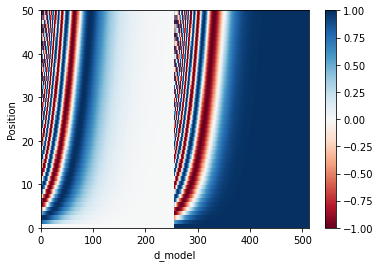

In [105]:
plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('d_model')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Encoder

In [106]:
class Encoder(tf.keras.layers.Layer):
  # Encoder 的初始參數除了本來就要給 EncoderLayer 的參數還多了：
  # - num_layers: 決定要有幾個 EncoderLayers, 前面影片中的 `N`
  # - input_vocab_size: 用來把索引轉成詞嵌入向量
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    
    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    # 建立 `num_layers` 個 EncoderLayers
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):
    # 輸入的 x.shape == (batch_size, input_seq_len)
    # 以下各 layer 的輸出皆為 (batch_size, input_seq_len, d_model)
    input_seq_len = tf.shape(x)[1]
    
    # 將 2 維的索引序列轉成 3 維的詞嵌入張量，並依照論文乘上 sqrt(d_model)
    # 再加上對應長度的位置編碼
    x = self.embedding(x)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :input_seq_len, :]

    # 對 embedding 跟位置編碼的總合做 regularization
    # 這在 Decoder 也會做
    x = self.dropout(x, training=training)
    
    # 通過 N 個 EncoderLayer 做編碼
    for i, enc_layer in enumerate(self.enc_layers):
      x = enc_layer(x, training, mask)
      # 以下只是用來 demo EncoderLayer outputs
      #print('-' * 20)
      #print(f"EncoderLayer {i + 1}'s output:", x)
      
    
    return x 

In [ ]:
# 超參數
num_layers = 2 # 2 層的 Encoder
d_model = 4
num_heads = 2
dff = 8
input_vocab_size = subword_encoder_en.vocab_size + 2 # 記得加上 <start>, <end>

# 初始化一個 Encoder
encoder = Encoder(num_layers, d_model, num_heads, dff, input_vocab_size)

# 將 2 維的索引序列丟入 Encoder 做編碼
enc_out = encoder(inp, training=False, mask=None)
print("inp:", inp)
print("-" * 20)
print("enc_out:", enc_out)

# Decoder

In [108]:
class Decoder(tf.keras.layers.Layer):
  # 初始參數跟 Encoder 只差在用 `target_vocab_size` 而非 `inp_vocab_size`
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    
    # 為中文（目標語言）建立詞嵌入層
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, self.d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
  
  # 呼叫時的參數跟 DecoderLayer 一模一樣
  def call(self, x, enc_output, training, 
           combined_mask, inp_padding_mask):
    
    tar_seq_len = tf.shape(x)[1]
    attention_weights = {}  # 用來存放每個 Decoder layer 的注意權重
    
    # 這邊跟 Encoder 做的事情完全一樣
    x = self.embedding(x)  # (batch_size, tar_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :tar_seq_len, :]
    x = self.dropout(x, training=training)

    
    for i, dec_layer in enumerate(self.dec_layers):
      x, block1, block2 = dec_layer(x, enc_output, training,
                                    combined_mask, inp_padding_mask)
      
      # 將從每個 Decoder layer 取得的注意權重全部存下來回傳，方便我們觀察
      attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2
    
    # x.shape == (batch_size, tar_seq_len, d_model)
    return x, attention_weights

In [ ]:
# 超參數
num_layers = 2 # 2 層的 Decoder
d_model = 4
num_heads = 2
dff = 8
target_vocab_size = subword_encoder_zh.vocab_size + 2 # 記得加上 <start>, <end>

# 遮罩
inp_padding_mask = create_padding_mask(inp)
tar_padding_mask = create_padding_mask(tar)
look_ahead_mask = create_look_ahead_mask(tar.shape[1])
combined_mask = tf.math.maximum(tar_padding_mask, look_ahead_mask)

# 初始化一個 Decoder
decoder = Decoder(num_layers, d_model, num_heads, dff, target_vocab_size)

# 將 2 維的索引序列以及遮罩丟入 Decoder
print("tar:", tar)
print("-" * 20)
print("combined_mask:", combined_mask)
print("-" * 20)
print("enc_out:", enc_out)
print("-" * 20)
print("inp_padding_mask:", inp_padding_mask)
print("-" * 20)
dec_out, attn = decoder(tar, enc_out, training=False, 
                        combined_mask=combined_mask,
                        inp_padding_mask=inp_padding_mask)
print("dec_out:", dec_out)
print("-" * 20)
for block_name, attn_weights in attn.items():
  print(f"{block_name}.shape: {attn_weights.shape}")

# Transformer

In [111]:
# Transformer 之上已經沒有其他 layers 了，我們使用 tf.keras.Model 建立一個模型
class Transformer(tf.keras.Model):
  # 初始參數包含 Encoder & Decoder 都需要超參數以及中英字典數目
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)
    # 這個 FFN 輸出跟中文字典一樣大的 logits 數，等通過 softmax 就代表每個中文字的出現機率
    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
  
  # enc_padding_mask 跟 dec_padding_mask 都是英文序列的 padding mask，
  # 只是一個給 Encoder layer 的 MHA 用，一個是給 Decoder layer 的 MHA 2 使用
  def call(self, inp, tar, training, enc_padding_mask, 
           combined_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, combined_mask, dec_padding_mask)
    
    # 將 Decoder 輸出通過最後一個 linear layer
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights